In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

RANDOM_STATE = 55 ## We will pass it to every sklearn call so we ensure reproducibility
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/andy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/andy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Wrangling

#### Read and Wrangle Dataset 1

In [8]:
df = pd.read_csv('data/SPAM_SMS.csv')
print(df.head()) 

   Unnamed: 0 masked_celphone_number                hashed_celphone_number  \
0           0          +63960****373  91caa5d6-1f97-3a2d-982b-5b0c021632ab   
1           1          +63981****852  f66589b7-4e6a-33ba-b7c5-d0dacb48552b   
2           2          +63946****113  1f332ce5-618e-32e6-b2ab-8e567917aeef   
3           3          +63950****934  5e6fcdc3-b2b8-3f71-b411-cacb8d40a0b9   
4           4          +63960****401  aafa248f-04ef-3005-a672-db79286919ee   

                      date                                               text  \
0  2022-11-12 14:02:10.079  Welcome ! your have P1222 for S!ot , \nWeb: 11...   
1  2022-11-12 14:33:48.916  My god, at least 999P rewards waiting for you\...   
2  2022-11-13 23:03:15.023  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...   
3  2022-11-14 00:07:18.715  <REAL NAME>! Today, you can win the iphone14PR...   
4  2022-11-15 02:28:56.636  Welcome ! your have P1222 for S!ot , \nWeb: gr...   

  carrier  
0   Smart  
1   Smart  
2     TN

In [9]:

df.drop(columns=['Unnamed: 0','masked_celphone_number','hashed_celphone_number', 'date', 'carrier'], inplace=True)
df['spam_tag'] = True
print(df.head())
print(df.size)

                                                text  spam_tag
0  Welcome ! your have P1222 for S!ot , \nWeb: 11...      True
1  My god, at least 999P rewards waiting for you\...      True
2  DEAR VIP <REAL NAME>, No. 1 Online Sabong Site...      True
3  <REAL NAME>! Today, you can win the iphone14PR...      True
4  Welcome ! your have P1222 for S!ot , \nWeb: gr...      True
1238


#### Read and Wrangle Dataset 2

In [10]:
df2 = pd.read_csv('data/spam.csv',encoding='latin1')
print(df2.head()) 

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [11]:
def boolize(row):
    if row['v1'] == 'ham':
        return False
    return True

In [12]:
df2['spam_tag'] = df2.apply(boolize, axis=1)
df2.rename(columns={'v2':'text'}, inplace=True)
df2.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4', 'v1'], inplace=True)
print(df2.head()) 
print(df2.size)

                                                text  spam_tag
0  Go until jurong point, crazy.. Available only ...     False
1                      Ok lar... Joking wif u oni...     False
2  Free entry in 2 a wkly comp to win FA Cup fina...      True
3  U dun say so early hor... U c already then say...     False
4  Nah I don't think he goes to usf, he lives aro...     False
11144


#### Combine Datasets 1 & 2 and Apply Preprocessing

In [13]:
dataset = pd.concat([df,df2])
# print(dataset['spam_tag'].head())
print(dataset.size)

12382


In [14]:
def preprocess_text(text):
    words = word_tokenize(text) #Tokenization
    words = [word.lower() for word in words if word.isalnum()] #to Lowercase
    words = [word for word in words if word not in stopwords.words("english")] #Remove Stopwords
    return " ".join(words) #Concate tokens

In [15]:
dataset['text'] = dataset['text'].apply(preprocess_text)
dataset = dataset.sample(frac=1) # shuffle the dataset
print(dataset.head())


                                                   text  spam_tag
5247    gud ni8 dear slp well take care swt dreams muah     False
2838          easy mate guess quick drink bit ambitious     False
4249                                        much eighth     False
3263              send email mind lt gt times per night     False
208   landbank alert mobile number currently suspend...      True


### One-Hot the Dataset

In [16]:
def tokenize(row):
    # print(f'{row["text"]}\n\n')
    lst = row['text'].split()
    ones = [True for item in lst]
    zipped = dict(zip(lst,ones))
    # print(zipped)
    return zipped

In [17]:
one_hot = dataset.apply(tokenize, axis=1, result_type='expand')
print(one_hot.head())
dataset_oh = pd.concat([dataset, one_hot], axis=1)

       gud   ni8  dear   slp  well  take  care   swt dreams  muah  ... cantdo  \
5247  True  True  True  True  True  True  True  True   True  True  ...    NaN   
2838   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN  ...    NaN   
4249   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN  ...    NaN   
3263   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN  ...    NaN   
208    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN    NaN   NaN  ...    NaN   

     anythingtomorrow myparents aretaking outfor mylife tattoos meive gotany  \
5247              NaN       NaN       NaN    NaN    NaN     NaN   NaN    NaN   
2838              NaN       NaN       NaN    NaN    NaN     NaN   NaN    NaN   
4249              NaN       NaN       NaN    NaN    NaN     NaN   NaN    NaN   
3263              NaN       NaN       NaN    NaN    NaN     NaN   NaN    NaN   
208               NaN       NaN       NaN    NaN    NaN     NaN   NaN    NaN   

     associate  
5247       NaN 

In [18]:
dataset_oh.fillna(False, inplace=True)
print(dataset_oh.head())

                                                   text  spam_tag    gud  \
5247    gud ni8 dear slp well take care swt dreams muah     False   True   
2838          easy mate guess quick drink bit ambitious     False  False   
4249                                        much eighth     False  False   
3263              send email mind lt gt times per night     False  False   
208   landbank alert mobile number currently suspend...      True  False   

        ni8   dear    slp   well   take   care    swt  ...  cantdo  \
5247   True   True   True   True   True   True   True  ...   False   
2838  False  False  False  False  False  False  False  ...   False   
4249  False  False  False  False  False  False  False  ...   False   
3263  False  False  False  False  False  False  False  ...   False   
208   False  False  False  False  False  False  False  ...   False   

      anythingtomorrow  myparents  aretaking  outfor  mylife  tattoos  meive  \
5247             False      False      Fal

In [19]:
# print(len(dataset_oh.columns))
# print(len(set(dataset_oh.columns)))
# print(dataset_oh)

#### Extract the Features X and Target Y

In [20]:
features = [x for x in dataset_oh.columns if x not in ['spam_tag','text']]
print(f'features length={len(features)}')

features length=8971


In [21]:
Y = dataset_oh['spam_tag']
X = dataset_oh[features]
print(X.head())
print(Y.head())

        gud    ni8   dear    slp   well   take   care    swt  dreams   muah  \
5247   True   True   True   True   True   True   True   True    True   True   
2838  False  False  False  False  False  False  False  False   False  False   
4249  False  False  False  False  False  False  False  False   False  False   
3263  False  False  False  False  False  False  False  False   False  False   
208   False  False  False  False  False  False  False  False   False  False   

      ...  cantdo  anythingtomorrow  myparents  aretaking  outfor  mylife  \
5247  ...   False             False      False      False   False   False   
2838  ...   False             False      False      False   False   False   
4249  ...   False             False      False      False   False   False   
3263  ...   False             False      False      False   False   False   
208   ...   False             False      False      False   False   False   

      tattoos  meive  gotany  associate  
5247    False  False

#### Split into Training, Validation and Test Sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.9, random_state = RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, random_state = RANDOM_STATE)

In [23]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'test samples: {len(X_test)}')

train samples: 4456
validation samples: 1115
test samples: 620


### Hyperparameters for Tuning

In [24]:
min_samples_split_list = [50, 100, 200, 500, 1000, 2000, 4000, 8000] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.
n_estimators_list = [10,50,100,500,1000]

# Decision Tree

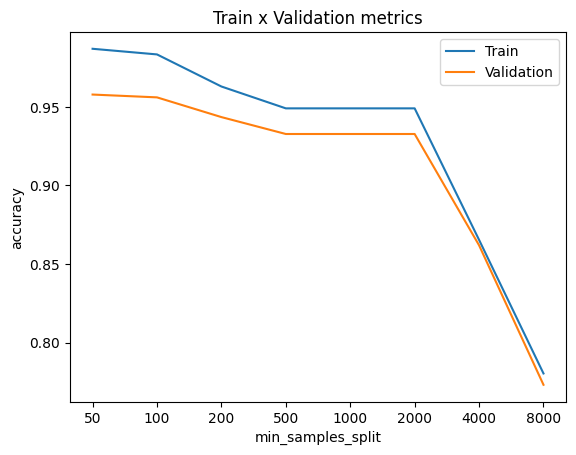

In [25]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

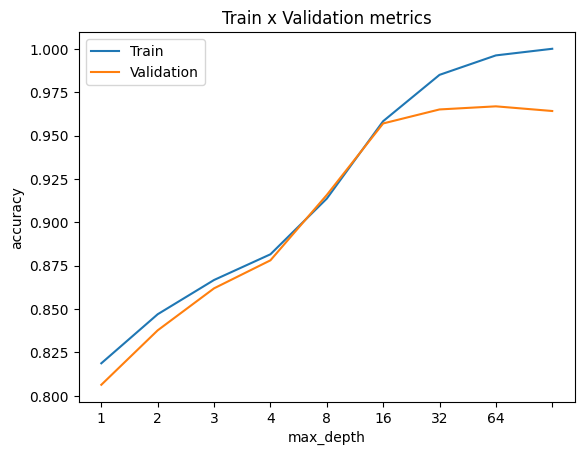

In [26]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = DecisionTreeClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

#### Final Model, using min sample split = 50 and max depth = 32

In [27]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 32,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [28]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_test),y_test):.4f}")

Metrics train:
	Accuracy score: 0.9742
Metrics validation:
	Accuracy score: 0.9468


# Random Forest

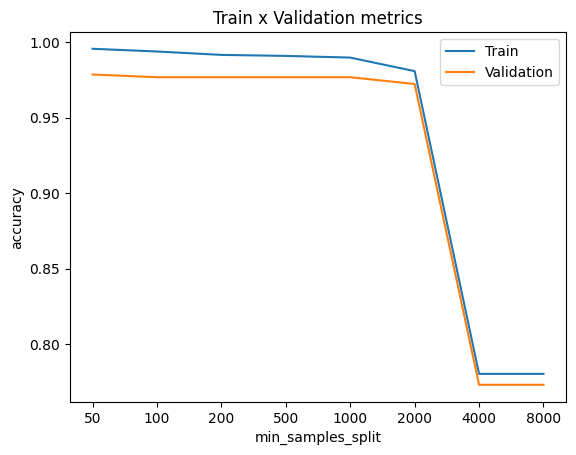

In [29]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

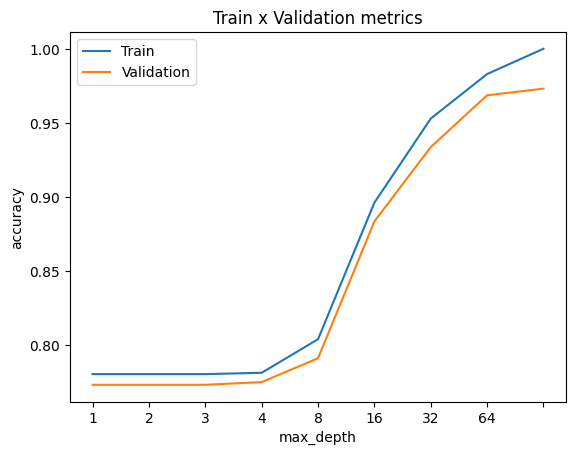

In [30]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

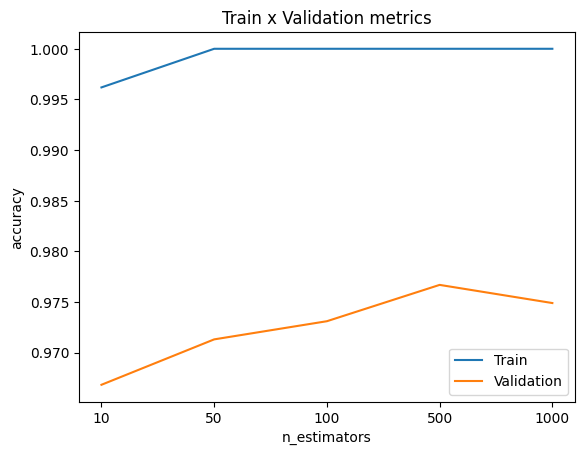

In [31]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train.values.ravel()) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

#### Final Model, using N-estimators = 500, max depth = 64, min samples split=100

In [39]:
random_forest_model = RandomForestClassifier(n_estimators = 500,
                                             max_depth = 64, 
                                             min_samples_split = 100).fit(X_train,y_train.values.ravel()) 

In [33]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9764
Metrics test:
	Accuracy score: 0.9659


# Manually entered Spam Messages

In [34]:
def is_spam(text):
    processed = preprocess_text(text).split()
    arr = np.zeros(len(features), dtype = bool)
    for i,text in enumerate(features):
        if text in processed:
            arr[i] = True
    data = dict(zip(features,arr))
    # print(data)
    df_new = pd.DataFrame(data, index=[0])
    # print(df_new)
    return random_forest_model.predict(df_new)[0]

In [38]:
# text = "get a chance to win 100! join now!"
# text = "click here to win prizes"
# text = "here na me, where na u?"
# text = "the quick brown fox jumps over the lazy dog into the river"
text = "the quick brown fox jumps over the lazy dog into the river, over $500 in prizes! call now to win!"
# text = "Receive 100P once use your number to register on:Filbet.com. No deposit,you may withdraw once the turnover reaches 1x. No Messages? Send STOP 10559 to 225687."
# text = "Congrats! You've won a $500 gift card. Click the link to claim your prize now:"
# text = "Hi, I saw your profile online. I would love to chat! Let's connect here: http://bit.ly/asfasdf"
# text = "Breaking: Prices are dropping! Save up to 70% only today. Shop now: http://bit.ly/asfasdf1"
# text = "You are the lucky winner of our monthly raffle! Claim your $1,000 cash prize now:http://bit.ly/asfasdf2"

print(is_spam(text))

True


# Check vs ChatGPT Generated Spam Mesasges

In [40]:
# df_gpt  = pd.read_csv('chatgpt_generated_spam.txt', names=['text'])
# print(df_gpt.head())
sms = []
with open('./data/chatgpt_generated_spam.txt') as f:
    line = 'sms'
    while line:
        line = f.readline()
        sms.append(line)
processed = [preprocess_text(x) for x in sms]
# print(processed)
values = []
for item in processed:
    arr = np.zeros(len(features), dtype = bool)
    for i,text in enumerate(features):
        if text in item.split():
            arr[i] = True
    values.append(np.copy(arr))
df_gpt = pd.DataFrame.from_records(values, columns = features)
df_gpt['spam'] = True
gpt_predictions = random_forest_model.predict(df_gpt[features])
y_gpt = pd.DataFrame(df_gpt['spam'])
# print(y_gpt)
# print(gpt_predictions)
print(f"Metrics GPT:\n\tAccuracy score: {accuracy_score(gpt_predictions, y_gpt):.4f}")

Metrics GPT:
	Accuracy score: 0.1833
